### 1. Data Ingestion & Storage
- Load large data files into Spark.
- Use RDDs to perform basic transformations (filter, map, reduce).
- Convert to DataFrames for SQL-based operations.


In [1]:
# Setup SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TaxiDataIngestion") \
    .getOrCreate()

In [2]:
# Adjust the path_pattern to match your local folder
# path_pattern = r"C:\Users\brian\OneDrive\Escritorio\Lambton\Semester3\3_BigDataFramework\12_Week12_Jul24\Project\Data\yellow_tripdata_2023-*.parquet"
path_pattern = r"C:\Users\brian\OneDrive\Escritorio\Lambton\Semester3\3_BigDataFramework\12_Week12_Jul24\Project\Data\yellow_tripdata_2023-01.parquet"

# Cell 2: read parquet files
df = spark.read.parquet(path_pattern)

In [3]:
# In this part we inspect the data
print("📋 Schema of the DataFrame:")
df.printSchema()

📋 Schema of the DataFrame:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [4]:
print("\n🔍 First 5 rows:")
df.show(5, truncate=False)


🔍 First 5 rows:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|2       |2023-01-01 00:32:10 |2023-01-01 00:40:36  |1.0            |0.97         |1.0       |N                 |161         |141         |2           |9.3        |1.0  |

### 2. Data Cleaning and Exploration
- Handle missing/null values, duplicates, and data type inconsistencies.
- Use Spark SQL to run queries, join datasets, and perform aggregations.


In [5]:
from pyspark.sql.functions import col

# 1. Remove exact duplicate rows to avoid biasing our analysis
df_clean = df.dropDuplicates()

In [6]:
# 2. Filter out trips with invalid or zero values:
#    - trip_distance must be positive
#    - passenger_count must be at least 1
#    - fare_amount must be positive
df_clean = df_clean.filter(
    (col("trip_distance") > 0) &
    (col("passenger_count") > 0) &
    (col("fare_amount") > 0)
)

In [7]:
# 3. Drop any rows with nulls in critical columns
df_clean = df_clean.na.drop(subset=[
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_distance",
    "fare_amount",
    "passenger_count"
])

In [8]:

# 4. Select only the columns we’ll need for feature engineering and modeling
df_clean = df_clean.select(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "payment_type",
    "PULocationID",
    "DOLocationID"
)

In [9]:
# 5. Print out how many rows remain after cleaning
print(f"Number of rows after cleaning: {df_clean.count()}")

Number of rows after cleaning: 2884228


In [10]:

# 6. Show summary statistics for our key numeric columns
df_clean.describe("trip_distance", "fare_amount", "passenger_count").show()

+-------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|   passenger_count|
+-------+------------------+------------------+------------------+
|  count|           2884228|           2884228|           2884228|
|   mean|3.4727680717336007| 18.54650707919073|1.3878611538338856|
| stddev|22.159084642338833|17.084855441426342|0.8883317343043949|
|    min|              0.01|              0.01|               1.0|
|    max|          14098.55|            1160.1|               8.0|
+-------+------------------+------------------+------------------+



3. Feature Engineering
- Use UDFs in Spark SQL or transformations with RDDs.
- Normalize/scale features and encode categorical data.


In [11]:
# Section 3: Feature Engineering

from pyspark.sql.functions import (
    unix_timestamp,
    hour,
    dayofweek,
    col
)

# 1. Compute trip_duration in minutes as (dropoff_timestamp – pickup_timestamp) / 60
# 2. Extract hour_of_day (0–23) from the pickup timestamp
# 3. Extract day_of_week (1 = Sunday … 7 = Saturday) from the pickup timestamp
df_features = (
    df_clean
    .withColumn(
        "trip_duration",
        (unix_timestamp(col("tpep_dropoff_datetime"))
         - unix_timestamp(col("tpep_pickup_datetime")))
        / 60.0
    )
    .withColumn("hour_of_day", hour(col("tpep_pickup_datetime")))
    .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
    .cache()  # keep these new columns in memory for faster downstream operations
)


In [12]:
# Preview the first 5 rows with our new features alongside original metrics
df_features.select(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_distance",
    "trip_duration",
    "hour_of_day",
    "day_of_week",
    "fare_amount"
).show(5, truncate=False)

+--------------------+---------------------+-------------+------------------+-----------+-----------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|trip_duration     |hour_of_day|day_of_week|fare_amount|
+--------------------+---------------------+-------------+------------------+-----------+-----------+-----------+
|2023-01-01 00:43:21 |2023-01-01 00:47:11  |0.4          |3.8333333333333335|0          |1          |5.8        |
|2023-01-01 00:42:27 |2023-01-01 00:51:46  |1.53         |9.316666666666666 |0          |1          |10.7       |
|2023-01-01 00:23:54 |2023-01-01 00:47:59  |2.41         |24.083333333333332|0          |1          |21.9       |
|2023-01-01 00:24:28 |2023-01-01 00:36:19  |1.95         |11.85             |0          |1          |13.5       |
|2023-01-01 00:53:09 |2023-01-01 01:12:27  |3.9          |19.3              |0          |1          |20.5       |
+--------------------+---------------------+-------------+------------------+-----------

4. Machine Learning Module (MLlib)
- Split data into training/test sets using MLlib.
- Train models (e.g., Logistic Regression, Decision Trees, KMeans).
- Evaluate model performance (accuracy, RMSE, etc.).

In [13]:
# Section 4: Model Training with MLlib

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Assemble input features into a single vector ("raw_features")
assembler = VectorAssembler(
    inputCols=[
        "trip_distance",
        "trip_duration",
        "passenger_count",
        "hour_of_day",
        "day_of_week",
        "payment_type"
    ],
    outputCol="raw_features"
)

In [14]:
# 2. Scale those features to zero mean and unit variance ("features")
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features"
)

In [15]:
# 3. Define a Linear Regression model to predict 'fare_amount'
lr = LinearRegression(
    featuresCol="features",
    labelCol="fare_amount",
    predictionCol="prediction"
)

In [16]:
# 4. Chain together assembler → scaler → regression in a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [17]:
# 5. Split your January dataset into 80% train / 20% test
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

In [18]:
# 6. Fit the pipeline on the training data
model = pipeline.fit(train_df)

In [19]:
# 7. Generate predictions on the test set
predictions = model.transform(test_df)

In [20]:
# 8. Evaluate performance: RMSE and R²
evaluator_rmse = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)

print(f"➡️ Test RMSE: {rmse:.2f}")
print(f"➡️ Test R²:   {r2:.2f}")



➡️ Test RMSE: 16.29
➡️ Test R²:   0.09


In [21]:
# 9. Show a few sample predictions side-by-side with actual fares
predictions.select(
    "trip_distance",
    "trip_duration",
    "passenger_count",
    "hour_of_day",
    "day_of_week",
    "payment_type",
    "fare_amount",
    "prediction"
).show(5, truncate=False)

+-------------+------------------+---------------+-----------+-----------+------------+-----------+------------------+
|trip_distance|trip_duration     |passenger_count|hour_of_day|day_of_week|payment_type|fare_amount|prediction        |
+-------------+------------------+---------------+-----------+-----------+------------+-----------+------------------+
|0.69         |2.8666666666666667|6.0            |0          |1          |1           |5.8        |20.015814402301245|
|19.46        |28.533333333333335|1.0            |0          |1          |1           |73.0       |22.54368053024152 |
|2.51         |15.45             |1.0            |0          |1          |1           |15.6       |18.995962705771564|
|2.3          |18.65             |1.0            |0          |1          |1           |17.7       |19.236995668293638|
|4.6          |27.916666666666668|1.0            |0          |1          |1           |27.5       |20.353398843270003|
+-------------+------------------+--------------

5. Visualization & Reporting
- Display insights from Spark SQL outputs.
- Plot results using visualization libraries.

In [22]:
import matplotlib.pyplot as plt

# 1. Take a small random sample (e.g. 5,000 rows) of the predictions for plotting
#    We select only what we need into a Pandas DataFrame
plot_df = (
    predictions
    .select("fare_amount", "prediction")
    .sample(withReplacement=False, fraction=0.01, seed=42)  # ~1% sample
    .toPandas()
)

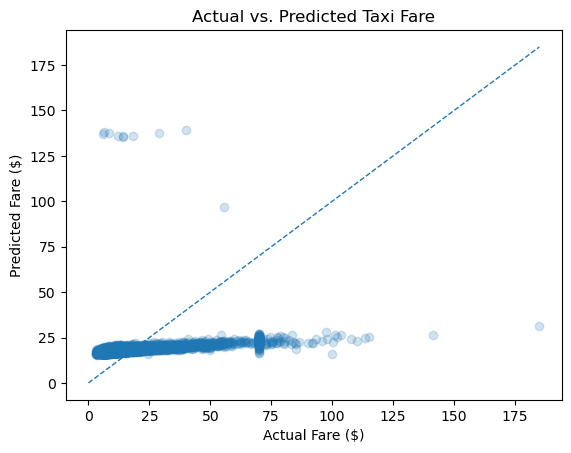

In [23]:
# 2. Scatter plot: Actual vs. Predicted fare
plt.figure()  # new figure
plt.scatter(plot_df["fare_amount"], plot_df["prediction"], alpha=0.2)
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title("Actual vs. Predicted Taxi Fare")
plt.plot([0, plot_df["fare_amount"].max()],
         [0, plot_df["fare_amount"].max()],
         linestyle="--", linewidth=1)  # 45° reference line
plt.show()



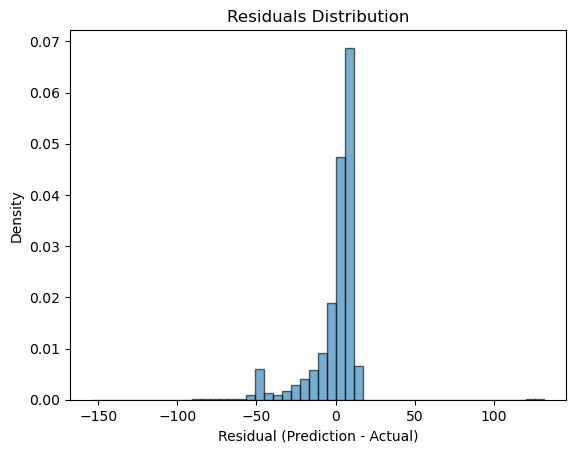

In [24]:
# 3. Compute residuals and plot their distribution
plot_df["residual"] = plot_df["prediction"] - plot_df["fare_amount"]

plt.figure()
plt.hist(plot_df["residual"], bins=50, edgecolor="k", density=True, alpha=0.6)
plt.xlabel("Residual (Prediction - Actual)")
plt.ylabel("Density")
plt.title("Residuals Distribution")
plt.show()

### Paso opcional de checar mas modelos 

In [25]:
# ── Section: Model Refinement & Tuning ──

from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator



In [26]:
# 1) Compute 1st and 99th percentiles for trip_distance, trip_duration, fare_amount
q_trip_dist = df_features.approxQuantile("trip_distance",  [0.01, 0.99], 0.01)
q_trip_dur  = df_features.approxQuantile("trip_duration",  [0.01, 0.99], 0.01)
q_fare_amt  = df_features.approxQuantile("fare_amount",    [0.01, 0.99], 0.01)

low_dist, high_dist = q_trip_dist
low_dur,  high_dur  = q_trip_dur
low_fare, high_fare = q_fare_amt



In [27]:
# 2) Filter out extreme outliers outside [1%, 99%] for those columns
df_refined = df_features.filter(
    (col("trip_distance")  >= low_dist)  & (col("trip_distance")  <= high_dist) &
    (col("trip_duration")  >= low_dur)   & (col("trip_duration")  <= high_dur)  &
    (col("fare_amount")    >= low_fare)  & (col("fare_amount")    <= high_fare)
).cache()

print("Rows before outlier removal:", df_features.count())
print("Rows after  outlier removal:", df_refined.count())



Rows before outlier removal: 2884228
Rows after  outlier removal: 2884228


In [28]:
# 3) Prepare assembler + scaler (same for all models)
assembler = VectorAssembler(
    inputCols=[
        "trip_distance", "trip_duration",
        "passenger_count", "hour_of_day",
        "day_of_week",    "payment_type"
    ],
    outputCol="raw_features"
)
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features"
)



In [29]:
# 4) Decision Tree pipeline
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    predictionCol="prediction",
    maxDepth=5  # you can tune this later
)
pipe_dt = Pipeline(stages=[assembler, scaler, dt])



In [30]:
# 5) Random Forest pipeline
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    predictionCol="prediction",
    seed=42
)
pipe_rf = Pipeline(stages=[assembler, scaler, rf])



In [31]:
# 6) Split refined data into train/test (80/20)
train_ref, test_ref = df_refined.randomSplit([0.8, 0.2], seed=42)



In [32]:
# 7) Fit Decision Tree and evaluate
model_dt = pipe_dt.fit(train_ref)
preds_dt = model_dt.transform(test_ref)
evaluator = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="rmse"
)
rmse_dt = evaluator.evaluate(preds_dt)
print(f"Decision Tree RMSE: {rmse_dt:.2f}")



Decision Tree RMSE: 5.73


In [33]:
# 8) Set up hyperparameter grid for Random Forest
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [20, 50])
    .addGrid(rf.maxDepth,  [5, 10])
    .build()
)



In [34]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# re-use assembler & scaler from before
assembler = VectorAssembler(
    inputCols=["trip_distance","trip_duration","passenger_count","hour_of_day","day_of_week","payment_type"],
    outputCol="raw_features"
)
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

rf_default = RandomForestRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    numTrees=50,
    maxDepth=7,
    seed=42
)
pipe_rf_default = Pipeline(stages=[assembler, scaler, rf_default])

model_rf_default = pipe_rf_default.fit(train_ref)   # train_ref from your January slice

# Evaluate
preds_rf_default = model_rf_default.transform(test_ref)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse_default = evaluator.evaluate(preds_rf_default)
print(f"Default RF RMSE: {rmse_default:.2f}")

# Peek at predictions
preds_rf_default.select(
    "trip_distance","trip_duration","passenger_count",
    "hour_of_day","day_of_week","payment_type",
    "fare_amount","prediction"
).show(5, truncate=False)


Default RF RMSE: 5.22
+-------------+------------------+---------------+-----------+-----------+------------+-----------+------------------+
|trip_distance|trip_duration     |passenger_count|hour_of_day|day_of_week|payment_type|fare_amount|prediction        |
+-------------+------------------+---------------+-----------+-----------+------------+-----------+------------------+
|0.69         |2.8666666666666667|6.0            |0          |1          |1           |5.8        |8.209177277470289 |
|19.46        |28.533333333333335|1.0            |0          |1          |1           |73.0       |67.77572289288877 |
|2.51         |15.45             |1.0            |0          |1          |1           |15.6       |17.149656939446672|
|2.3          |18.65             |1.0            |0          |1          |1           |17.7       |17.826061449152814|
|4.6          |27.916666666666668|1.0            |0          |1          |1           |27.5       |29.125359628861837|
+-------------+-----------

In [35]:
# 9) 3-fold CrossValidator on Random Forest
cv = CrossValidator(
    estimator=pipe_rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2  # trains folds in parallel
)

# instead of cvModel = cv.fit(train_ref)
cvModel = cv.fit(train_ref, paramGrid)


Py4JJavaError: An error occurred while calling o2295.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 239.0 failed 1 times, most recent failure: Lost task 5.0 in stage 239.0 (TID 24500) (Brian executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.Integer.valueOf(Integer.java:1059)
	at scala.runtime.BoxesRunTime.boxToInteger(BoxesRunTime.java:67)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$8(RandomForest.scala:561)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$8$adapted(RandomForest.scala:558)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7178/0x0000000101b40040.apply(Unknown Source)
	at scala.collection.immutable.HashMap$HashMap1.foreach(HashMap.scala:400)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:728)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:728)
	at org.apache.spark.ml.tree.impl.RandomForest$.binSeqOp$1(RandomForest.scala:558)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$24(RandomForest.scala:655)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7170/0x0000000101b4c840.apply(Unknown Source)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:655)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7120/0x0000000101bc1840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$1664/0x0000000100c33c40.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1625/0x0000000100c08c40.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.regression.RandomForestRegressor.$anonfun$train$1(RandomForestRegressor.scala:158)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:136)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:45)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.Integer.valueOf(Integer.java:1059)
	at scala.runtime.BoxesRunTime.boxToInteger(BoxesRunTime.java:67)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$8(RandomForest.scala:561)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$8$adapted(RandomForest.scala:558)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7178/0x0000000101b40040.apply(Unknown Source)
	at scala.collection.immutable.HashMap$HashMap1.foreach(HashMap.scala:400)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:728)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:728)
	at org.apache.spark.ml.tree.impl.RandomForest$.binSeqOp$1(RandomForest.scala:558)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$24(RandomForest.scala:655)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7170/0x0000000101b4c840.apply(Unknown Source)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:655)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$7120/0x0000000101bc1840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$1664/0x0000000100c33c40.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1625/0x0000000100c08c40.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)


In [36]:
# 10) Evaluate best RF on test set
preds_rf = cvModel.transform(test_ref)
rmse_rf = evaluator.evaluate(preds_rf)
print(f"Random Forest RMSE (tuned): {rmse_rf:.2f}")




NameError: name 'cvModel' is not defined

In [37]:
# 11) Print best hyperparameters
best_rf = cvModel.bestModel.stages[-1]
print("🏆 Best RF numTrees:", best_rf.getNumTrees)
print("🏆 Best RF maxDepth:", best_rf.getOrDefault("maxDepth"))



NameError: name 'cvModel' is not defined

In [ ]:
# 12) Compare on a few sample rows
preds_rf.select(
    "trip_distance", "trip_duration",
    "passenger_count", "hour_of_day",
    "day_of_week", "payment_type",
    "fare_amount", "prediction"
).show(5, truncate=False)

6. Frontend Interface
- Provide options for input/upload.
- Display summary tables, charts, model results interactively.